# Data

In [1]:
using Distributions
using FillArrays
using StatsPlots

using LinearAlgebra
using Random

using Turing

# Set a random seed.
Random.seed!(3)

# Define Gaussian mixture model.
w = [0.5, 0.5] # weights for clusters (can be viewed as priors)
μ = [-3.5, 0.5] # means for clusters
mixturemodel = MixtureModel([MvNormal(Fill(μₖ, 2), I) for μₖ in μ], w)

# We draw the data points.
N = 60 # number of data points in each cluster
x = TArray(rand(mixturemodel, N)); # 2x60 Matrix{Float64} (dimension x datapoints)

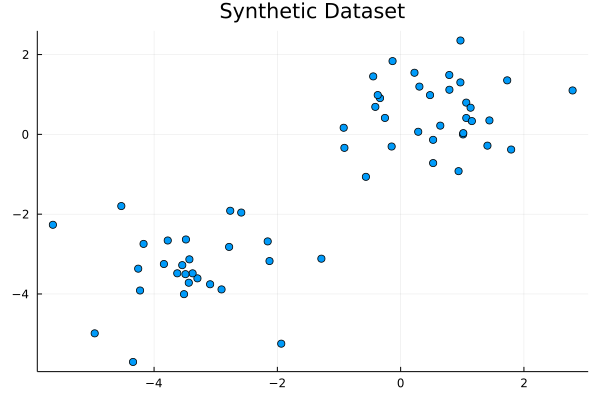

In [2]:
scatter(x[1, :], x[2, :]; legend=false, title="Synthetic Dataset")

In [3]:
using Turing

function init_param(x; K=2)
    D, _ = size(x)
    return μ = rand(MvNormal(Zeros(D), I), K)
end

@model function em_gmm(x, param; k=missing, K=2)
    D, N = size(x)
    # Parameters: MVNs' means
    μ = param
    # Priors/weights of μs
    w = fill(1/K, K)
    # Distribution assignments
    r = Categorical(w)
    # Clusters (posterior MVNs)
    𝓝 = [MvNormal(Fill(μₖ, D), I) for μₖ in μ]

    if ismissing(k)
        # k = Vector{Int}(undef, N)
        k = tzeros(Int, N)
        k_missing = true
    else
        k_missing = false
    end

    for i in 1:N
        if k_missing
            k[i] ~ r
        end
        x[:, i] ~ 𝓝[k[i]]
    end
    
    return k
end

em_gmm (generic function with 2 methods)

## Loop

In [12]:
using Optim

function get_k(chain; keep_pct=.5, use_every=10)
    data = chain.value.data[:, 1:60]
    n_keep = floor(Int, keep_pct * size(data)[1])
    k = Matrix{Int}(data[end-n_keep+1 : use_every : end, :])
    return k
end

function makeobj(chain)
    obj(param) = -logjoint(em_gmm(x, param), (k = get_k(chain), ))
    return obj
end

# Alg (hyper)parameters

n_iterations = 5
n_samples = 100
n_particles = 1000

# Sampler
## 1. Simple PG
sampler = PG(n_particles, :k)
## 2. Not so simple PG
# sampler = Gibbs(PG(n_samples, :k))
## 3. Simple HMC
# sampler = HMC(.1, 5, :k)
## 4. Not so simple HMC
# sampler = Gibbs(PG(n_samples, :k), HMC(0.1, 5))
## 5. NUTS
# sampler = NUTS(0.65)
## 6. SMC
# sampler = SMC()

# Process history
# chain_history = []
# optim_history = []
# k_history = []

for i in 1:n_iterations
    # Prepare parameters
    param = isempty(optim_history) ? init_param(x) : optim_history[end].minimizer
    # Prepare latent
    k = isempty(k_history) ? missing : k_history[end]

    # E-step
    chain = deepcopy(sample(em_gmm(x, param), sampler, n_samples))
    
    # M-step
    obj = makeobj(chain)
    optim = optimize(obj, param)
    
    # History
    push!(chain_history, deepcopy(chain))
    push!(optim_history, deepcopy(optim))
    push!(k_history, deepcopy(get_k(chain)))
end

Sampling   0%|                                          |  ETA: N/A


Sampling   1%|▍                                         |  ETA: 0:00:39


Sampling   2%|▉                                         |  ETA: 0:00:41


Sampling   3%|█▎                                        |  ETA: 0:00:41


Sampling   4%|█▋                                        |  ETA: 0:00:40


Sampling   5%|██▏                                       |  ETA: 0:00:40


Sampling   6%|██▌                                       |  ETA: 0:00:39


Sampling   7%|███                                       |  ETA: 0:00:39


Sampling   8%|███▍                                      |  ETA: 0:00:38


Sampling   9%|███▊                                      |  ETA: 0:00:38


Sampling  10%|████▎                                     |  ETA: 0:00:38


Sampling  11%|████▋                                     |  ETA: 0:00:37


Sampling  12%|█████                                     |  ETA: 0:00:37


Sampling  13%|█████▌                                    |  ETA: 0:00:36


Sampling  14%|█████▉                                    |  ETA: 0:00:36


Sampling  15%|██████▎                                   |  ETA: 0:00:35


Sampling  16%|██████▊                                   |  ETA: 0:00:35


Sampling  17%|███████▏                                  |  ETA: 0:00:35


Sampling  18%|███████▌                                  |  ETA: 0:00:34


Sampling  19%|████████                                  |  ETA: 0:00:34


Sampling  20%|████████▍                                 |  ETA: 0:00:33


Sampling  21%|████████▉                                 |  ETA: 0:00:33


Sampling  22%|█████████▎                                |  ETA: 0:00:33


Sampling  23%|█████████▋                                |  ETA: 0:00:32


Sampling  24%|██████████▏                               |  ETA: 0:00:32


Sampling  25%|██████████▌                               |  ETA: 0:00:31


Sampling  26%|██████████▉                               |  ETA: 0:00:31


Sampling  27%|███████████▍                              |  ETA: 0:00:31


Sampling  28%|███████████▊                              |  ETA: 0:00:30


Sampling  29%|████████████▏                             |  ETA: 0:00:30


Sampling  30%|████████████▋                             |  ETA: 0:00:30


Sampling  31%|█████████████                             |  ETA: 0:00:29


Sampling  32%|█████████████▌                            |  ETA: 0:00:29


Sampling  33%|█████████████▉                            |  ETA: 0:00:28


Sampling  34%|██████████████▎                           |  ETA: 0:00:28


Sampling  35%|██████████████▊                           |  ETA: 0:00:27


Sampling  36%|███████████████▏                          |  ETA: 0:00:27


Sampling  37%|███████████████▌                          |  ETA: 0:00:27


Sampling  38%|████████████████                          |  ETA: 0:00:26


Sampling  39%|████████████████▍                         |  ETA: 0:00:26


Sampling  40%|████████████████▊                         |  ETA: 0:00:25


Sampling  41%|█████████████████▎                        |  ETA: 0:00:25


Sampling  42%|█████████████████▋                        |  ETA: 0:00:24


Sampling  43%|██████████████████                        |  ETA: 0:00:24


Sampling  44%|██████████████████▌                       |  ETA: 0:00:24


Sampling  45%|██████████████████▉                       |  ETA: 0:00:23


Sampling  46%|███████████████████▍                      |  ETA: 0:00:23


Sampling  47%|███████████████████▊                      |  ETA: 0:00:22


Sampling  48%|████████████████████▏                     |  ETA: 0:00:22


Sampling  49%|████████████████████▋                     |  ETA: 0:00:21


Sampling  50%|█████████████████████                     |  ETA: 0:00:21


Sampling  51%|█████████████████████▍                    |  ETA: 0:00:21


Sampling  52%|█████████████████████▉                    |  ETA: 0:00:20


Sampling  53%|██████████████████████▎                   |  ETA: 0:00:20


Sampling  54%|██████████████████████▋                   |  ETA: 0:00:19


Sampling  55%|███████████████████████▏                  |  ETA: 0:00:19


Sampling  56%|███████████████████████▌                  |  ETA: 0:00:19


Sampling  57%|████████████████████████                  |  ETA: 0:00:18


Sampling  58%|████████████████████████▍                 |  ETA: 0:00:18


Sampling  59%|████████████████████████▊                 |  ETA: 0:00:17


Sampling  60%|█████████████████████████▎                |  ETA: 0:00:17


Sampling  61%|█████████████████████████▋                |  ETA: 0:00:16


Sampling  62%|██████████████████████████                |  ETA: 0:00:16


Sampling  63%|██████████████████████████▌               |  ETA: 0:00:16


Sampling  64%|██████████████████████████▉               |  ETA: 0:00:15


Sampling  65%|███████████████████████████▎              |  ETA: 0:00:15


Sampling  66%|███████████████████████████▊              |  ETA: 0:00:14


Sampling  67%|████████████████████████████▏             |  ETA: 0:00:14


Sampling  68%|████████████████████████████▌             |  ETA: 0:00:13


Sampling  69%|█████████████████████████████             |  ETA: 0:00:13


Sampling  70%|█████████████████████████████▍            |  ETA: 0:00:13


Sampling  71%|█████████████████████████████▉            |  ETA: 0:00:12


Sampling  72%|██████████████████████████████▎           |  ETA: 0:00:12


Sampling  73%|██████████████████████████████▋           |  ETA: 0:00:11


Sampling  74%|███████████████████████████████▏          |  ETA: 0:00:11


Sampling  75%|███████████████████████████████▌          |  ETA: 0:00:10


Sampling  76%|███████████████████████████████▉          |  ETA: 0:00:10


Sampling  77%|████████████████████████████████▍         |  ETA: 0:00:10


Sampling  78%|████████████████████████████████▊         |  ETA: 0:00:09


Sampling  79%|█████████████████████████████████▏        |  ETA: 0:00:09


Sampling  80%|█████████████████████████████████▋        |  ETA: 0:00:08


Sampling  81%|██████████████████████████████████        |  ETA: 0:00:08


Sampling  82%|██████████████████████████████████▌       |  ETA: 0:00:08


Sampling  83%|██████████████████████████████████▉       |  ETA: 0:00:07


Sampling  84%|███████████████████████████████████▎      |  ETA: 0:00:07


Sampling  85%|███████████████████████████████████▊      |  ETA: 0:00:06


Sampling  86%|████████████████████████████████████▏     |  ETA: 0:00:06


Sampling  87%|████████████████████████████████████▌     |  ETA: 0:00:05


Sampling  88%|█████████████████████████████████████     |  ETA: 0:00:05


Sampling  89%|█████████████████████████████████████▍    |  ETA: 0:00:05


Sampling  90%|█████████████████████████████████████▊    |  ETA: 0:00:04


Sampling  91%|██████████████████████████████████████▎   |  ETA: 0:00:04


Sampling  92%|██████████████████████████████████████▋   |  ETA: 0:00:03


Sampling  93%|███████████████████████████████████████   |  ETA: 0:00:03


Sampling  94%|███████████████████████████████████████▌  |  ETA: 0:00:03


Sampling  95%|███████████████████████████████████████▉  |  ETA: 0:00:02


Sampling  96%|████████████████████████████████████████▍ |  ETA: 0:00:02


Sampling  97%|████████████████████████████████████████▊ |  ETA: 0:00:01


Sampling  98%|█████████████████████████████████████████▏|  ETA: 0:00:01


Sampling  99%|█████████████████████████████████████████▋|  ETA: 0:00:00


Sampling 100%|██████████████████████████████████████████| Time: 0:00:42
Sampling 100%|██████████████████████████████████████████| Time: 0:00:42


Sampling   0%|                                          |  ETA: N/A


Sampling   1%|▍                                         |  ETA: 0:00:32


Sampling   2%|▉                                         |  ETA: 0:00:34


Sampling   3%|█▎                                        |  ETA: 0:00:34


Sampling   4%|█▋                                        |  ETA: 0:00:33


Sampling   5%|██▏                                       |  ETA: 0:00:33


Sampling   6%|██▌                                       |  ETA: 0:00:33


Sampling   7%|███                                       |  ETA: 0:00:33


Sampling   8%|███▍                                      |  ETA: 0:00:32


Sampling   9%|███▊                                      |  ETA: 0:00:32


Sampling  10%|████▎                                     |  ETA: 0:00:32


Sampling  11%|████▋                                     |  ETA: 0:00:31


Sampling  12%|█████                                     |  ETA: 0:00:31


Sampling  13%|█████▌                                    |  ETA: 0:00:31


Sampling  14%|█████▉                                    |  ETA: 0:00:30


Sampling  15%|██████▎                                   |  ETA: 0:00:30


Sampling  16%|██████▊                                   |  ETA: 0:00:30


Sampling  17%|███████▏                                  |  ETA: 0:00:29


Sampling  18%|███████▌                                  |  ETA: 0:00:29


Sampling  19%|████████                                  |  ETA: 0:00:29


Sampling  20%|████████▍                                 |  ETA: 0:00:28


Sampling  21%|████████▉                                 |  ETA: 0:00:28


Sampling  22%|█████████▎                                |  ETA: 0:00:27


Sampling  23%|█████████▋                                |  ETA: 0:00:27


Sampling  24%|██████████▏                               |  ETA: 0:00:27


Sampling  25%|██████████▌                               |  ETA: 0:00:26


Sampling  26%|██████████▉                               |  ETA: 0:00:26


Sampling  27%|███████████▍                              |  ETA: 0:00:26


Sampling  28%|███████████▊                              |  ETA: 0:00:25


Sampling  29%|████████████▏                             |  ETA: 0:00:25


Sampling  30%|████████████▋                             |  ETA: 0:00:25


Sampling  31%|█████████████                             |  ETA: 0:00:24


Sampling  32%|█████████████▌                            |  ETA: 0:00:24


Sampling  33%|█████████████▉                            |  ETA: 0:00:24


Sampling  34%|██████████████▎                           |  ETA: 0:00:23


Sampling  35%|██████████████▊                           |  ETA: 0:00:23


Sampling  36%|███████████████▏                          |  ETA: 0:00:23


Sampling  37%|███████████████▌                          |  ETA: 0:00:22


Sampling  38%|████████████████                          |  ETA: 0:00:22


Sampling  39%|████████████████▍                         |  ETA: 0:00:22


Sampling  40%|████████████████▊                         |  ETA: 0:00:21


Sampling  41%|█████████████████▎                        |  ETA: 0:00:21


Sampling  42%|█████████████████▋                        |  ETA: 0:00:21


Sampling  43%|██████████████████                        |  ETA: 0:00:20


Sampling  44%|██████████████████▌                       |  ETA: 0:00:20


Sampling  45%|██████████████████▉                       |  ETA: 0:00:20


Sampling  46%|███████████████████▍                      |  ETA: 0:00:20


Sampling  47%|███████████████████▊                      |  ETA: 0:00:19


Sampling  48%|████████████████████▏                     |  ETA: 0:00:19


Sampling  49%|████████████████████▋                     |  ETA: 0:00:19


Sampling  50%|█████████████████████                     |  ETA: 0:00:18


Sampling  51%|█████████████████████▍                    |  ETA: 0:00:18


Sampling  52%|█████████████████████▉                    |  ETA: 0:00:18


Sampling  53%|██████████████████████▎                   |  ETA: 0:00:17


Sampling  54%|██████████████████████▋                   |  ETA: 0:00:17


Sampling  55%|███████████████████████▏                  |  ETA: 0:00:17


Sampling  56%|███████████████████████▌                  |  ETA: 0:00:16


Sampling  57%|████████████████████████                  |  ETA: 0:00:16


Sampling  58%|████████████████████████▍                 |  ETA: 0:00:16


Sampling  59%|████████████████████████▊                 |  ETA: 0:00:15


Sampling  60%|█████████████████████████▎                |  ETA: 0:00:15


Sampling  61%|█████████████████████████▋                |  ETA: 0:00:15


Sampling  62%|██████████████████████████                |  ETA: 0:00:14


Sampling  63%|██████████████████████████▌               |  ETA: 0:00:14


Sampling  64%|██████████████████████████▉               |  ETA: 0:00:13


Sampling  65%|███████████████████████████▎              |  ETA: 0:00:13


Sampling  66%|███████████████████████████▊              |  ETA: 0:00:13


Sampling  67%|████████████████████████████▏             |  ETA: 0:00:12


Sampling  68%|████████████████████████████▌             |  ETA: 0:00:12


Sampling  69%|█████████████████████████████             |  ETA: 0:00:12


Sampling  70%|█████████████████████████████▍            |  ETA: 0:00:11


Sampling  71%|█████████████████████████████▉            |  ETA: 0:00:11


Sampling  72%|██████████████████████████████▎           |  ETA: 0:00:11


Sampling  73%|██████████████████████████████▋           |  ETA: 0:00:10


Sampling  74%|███████████████████████████████▏          |  ETA: 0:00:10


Sampling  75%|███████████████████████████████▌          |  ETA: 0:00:09


Sampling  76%|███████████████████████████████▉          |  ETA: 0:00:09


Sampling  77%|████████████████████████████████▍         |  ETA: 0:00:09


Sampling  78%|████████████████████████████████▊         |  ETA: 0:00:08


Sampling  79%|█████████████████████████████████▏        |  ETA: 0:00:08


Sampling  80%|█████████████████████████████████▋        |  ETA: 0:00:08


Sampling  81%|██████████████████████████████████        |  ETA: 0:00:07


Sampling  82%|██████████████████████████████████▌       |  ETA: 0:00:07


Sampling  83%|██████████████████████████████████▉       |  ETA: 0:00:06


Sampling  84%|███████████████████████████████████▎      |  ETA: 0:00:06


Sampling  85%|███████████████████████████████████▊      |  ETA: 0:00:06


Sampling  86%|████████████████████████████████████▏     |  ETA: 0:00:05


Sampling  87%|████████████████████████████████████▌     |  ETA: 0:00:05


Sampling  88%|█████████████████████████████████████     |  ETA: 0:00:05


Sampling  89%|█████████████████████████████████████▍    |  ETA: 0:00:04


Sampling  90%|█████████████████████████████████████▊    |  ETA: 0:00:04


Sampling  91%|██████████████████████████████████████▎   |  ETA: 0:00:03


Sampling  92%|██████████████████████████████████████▋   |  ETA: 0:00:03


Sampling  93%|███████████████████████████████████████   |  ETA: 0:00:03


Sampling  94%|███████████████████████████████████████▌  |  ETA: 0:00:02


Sampling  95%|███████████████████████████████████████▉  |  ETA: 0:00:02


Sampling  96%|████████████████████████████████████████▍ |  ETA: 0:00:02


Sampling  97%|████████████████████████████████████████▊ |  ETA: 0:00:01


Sampling  98%|█████████████████████████████████████████▏|  ETA: 0:00:01


Sampling  99%|█████████████████████████████████████████▋|  ETA: 0:00:00


Sampling 100%|██████████████████████████████████████████| Time: 0:00:38
Sampling 100%|██████████████████████████████████████████| Time: 0:00:38
Sampling   0%|                                          |  ETA: N/A


Sampling   1%|▍                                         |  ETA: 0:00:45


Sampling   2%|▉                                         |  ETA: 0:00:46


Sampling   3%|█▎                                        |  ETA: 0:00:48


Sampling   4%|█▋                                        |  ETA: 0:00:48


Sampling   5%|██▏                                       |  ETA: 0:00:47


Sampling   6%|██▌                                       |  ETA: 0:00:47


Sampling   7%|███                                       |  ETA: 0:00:47


Sampling   8%|███▍                                      |  ETA: 0:00:46


Sampling   9%|███▊                                      |  ETA: 0:00:46


Sampling  10%|████▎                                     |  ETA: 0:00:45


Sampling  11%|████▋                                     |  ETA: 0:00:45


Sampling  12%|█████                                     |  ETA: 0:00:45


Sampling  13%|█████▌                                    |  ETA: 0:00:44


Sampling  14%|█████▉                                    |  ETA: 0:00:44


Sampling  15%|██████▎                                   |  ETA: 0:00:43


Sampling  16%|██████▊                                   |  ETA: 0:00:43


Sampling  17%|███████▏                                  |  ETA: 0:00:42


Sampling  18%|███████▌                                  |  ETA: 0:00:42


Sampling  19%|████████                                  |  ETA: 0:00:41


Sampling  20%|████████▍                                 |  ETA: 0:00:41


Sampling  21%|████████▉                                 |  ETA: 0:00:40


Sampling  22%|█████████▎                                |  ETA: 0:00:40


Sampling  23%|█████████▋                                |  ETA: 0:00:39


Sampling  24%|██████████▏                               |  ETA: 0:00:39


Sampling  25%|██████████▌                               |  ETA: 0:00:39


Sampling  26%|██████████▉                               |  ETA: 0:00:38


Sampling  27%|███████████▍                              |  ETA: 0:00:38


Sampling  28%|███████████▊                              |  ETA: 0:00:37


Sampling  29%|████████████▏                             |  ETA: 0:00:37


Sampling  30%|████████████▋                             |  ETA: 0:00:36


Sampling  31%|█████████████                             |  ETA: 0:00:36


Sampling  32%|█████████████▌                            |  ETA: 0:00:35


Sampling  33%|█████████████▉                            |  ETA: 0:00:35


Sampling  34%|██████████████▎                           |  ETA: 0:00:34


Sampling  35%|██████████████▊                           |  ETA: 0:00:34


Sampling  36%|███████████████▏                          |  ETA: 0:00:33


Sampling  37%|███████████████▌                          |  ETA: 0:00:33


Sampling  38%|████████████████                          |  ETA: 0:00:32


Sampling  39%|████████████████▍                         |  ETA: 0:00:32


Sampling  40%|████████████████▊                         |  ETA: 0:00:31


Sampling  41%|█████████████████▎                        |  ETA: 0:00:31


Sampling  42%|█████████████████▋                        |  ETA: 0:00:30


Sampling  43%|██████████████████                        |  ETA: 0:00:30


Sampling  44%|██████████████████▌                       |  ETA: 0:00:29


Sampling  45%|██████████████████▉                       |  ETA: 0:00:28


Sampling  46%|███████████████████▍                      |  ETA: 0:00:28


Sampling  47%|███████████████████▊                      |  ETA: 0:00:27


Sampling  48%|████████████████████▏                     |  ETA: 0:00:27


Sampling  49%|████████████████████▋                     |  ETA: 0:00:26


Sampling  50%|█████████████████████                     |  ETA: 0:00:26


Sampling  51%|█████████████████████▍                    |  ETA: 0:00:25


Sampling  52%|█████████████████████▉                    |  ETA: 0:00:25


Sampling  53%|██████████████████████▎                   |  ETA: 0:00:24


Sampling  54%|██████████████████████▋                   |  ETA: 0:00:24


Sampling  55%|███████████████████████▏                  |  ETA: 0:00:23


Sampling  56%|███████████████████████▌                  |  ETA: 0:00:23


Sampling  57%|████████████████████████                  |  ETA: 0:00:22


Sampling  58%|████████████████████████▍                 |  ETA: 0:00:22


Sampling  59%|████████████████████████▊                 |  ETA: 0:00:21


Sampling  60%|█████████████████████████▎                |  ETA: 0:00:21


Sampling  61%|█████████████████████████▋                |  ETA: 0:00:20


Sampling  62%|██████████████████████████                |  ETA: 0:00:20


Sampling  63%|██████████████████████████▌               |  ETA: 0:00:19


Sampling  64%|██████████████████████████▉               |  ETA: 0:00:19


Sampling  65%|███████████████████████████▎              |  ETA: 0:00:18


Sampling  66%|███████████████████████████▊              |  ETA: 0:00:18


Sampling  67%|████████████████████████████▏             |  ETA: 0:00:17


Sampling  68%|████████████████████████████▌             |  ETA: 0:00:17


Sampling  69%|█████████████████████████████             |  ETA: 0:00:16


Sampling  70%|█████████████████████████████▍            |  ETA: 0:00:16


Sampling  71%|█████████████████████████████▉            |  ETA: 0:00:15


Sampling  72%|██████████████████████████████▎           |  ETA: 0:00:14


Sampling  73%|██████████████████████████████▋           |  ETA: 0:00:14


Sampling  74%|███████████████████████████████▏          |  ETA: 0:00:13


Sampling  75%|███████████████████████████████▌          |  ETA: 0:00:13


Sampling  76%|███████████████████████████████▉          |  ETA: 0:00:12


Sampling  77%|████████████████████████████████▍         |  ETA: 0:00:12


Sampling  78%|████████████████████████████████▊         |  ETA: 0:00:11


Sampling  79%|█████████████████████████████████▏        |  ETA: 0:00:11


Sampling  80%|█████████████████████████████████▋        |  ETA: 0:00:10


Sampling  81%|██████████████████████████████████        |  ETA: 0:00:10


Sampling  82%|██████████████████████████████████▌       |  ETA: 0:00:09


Sampling  83%|██████████████████████████████████▉       |  ETA: 0:00:09


Sampling  84%|███████████████████████████████████▎      |  ETA: 0:00:08


Sampling  85%|███████████████████████████████████▊      |  ETA: 0:00:08


Sampling  86%|████████████████████████████████████▏     |  ETA: 0:00:07


Sampling  87%|████████████████████████████████████▌     |  ETA: 0:00:07


Sampling  88%|█████████████████████████████████████     |  ETA: 0:00:06


Sampling  89%|█████████████████████████████████████▍    |  ETA: 0:00:06


Sampling  90%|█████████████████████████████████████▊    |  ETA: 0:00:05


Sampling  91%|██████████████████████████████████████▎   |  ETA: 0:00:05


Sampling  92%|██████████████████████████████████████▋   |  ETA: 0:00:04


Sampling  93%|███████████████████████████████████████   |  ETA: 0:00:04


Sampling  94%|███████████████████████████████████████▌  |  ETA: 0:00:03


Sampling  95%|███████████████████████████████████████▉  |  ETA: 0:00:03


Sampling  96%|████████████████████████████████████████▍ |  ETA: 0:00:02


Sampling  97%|████████████████████████████████████████▊ |  ETA: 0:00:02


Sampling  98%|█████████████████████████████████████████▏|  ETA: 0:00:01


Sampling  99%|█████████████████████████████████████████▋|  ETA: 0:00:01


Sampling 100%|██████████████████████████████████████████| Time: 0:00:51
Sampling 100%|██████████████████████████████████████████| Time: 0:00:51
Sampling   0%|                                          |  ETA: N/A


Sampling   1%|▍                                         |  ETA: 0:00:40


Sampling   2%|▉                                         |  ETA: 0:00:40


Sampling   3%|█▎                                        |  ETA: 0:00:40


Sampling   4%|█▋                                        |  ETA: 0:00:40


Sampling   5%|██▏                                       |  ETA: 0:00:38


Sampling   6%|██▌                                       |  ETA: 0:00:38


Sampling   7%|███                                       |  ETA: 0:00:38


Sampling   8%|███▍                                      |  ETA: 0:00:38


Sampling   9%|███▊                                      |  ETA: 0:00:38


Sampling  10%|████▎                                     |  ETA: 0:00:37


Sampling  11%|████▋                                     |  ETA: 0:00:36


Sampling  12%|█████                                     |  ETA: 0:00:36


Sampling  13%|█████▌                                    |  ETA: 0:00:35


Sampling  14%|█████▉                                    |  ETA: 0:00:35


Sampling  15%|██████▎                                   |  ETA: 0:00:34


Sampling  16%|██████▊                                   |  ETA: 0:00:34


Sampling  17%|███████▏                                  |  ETA: 0:00:34


Sampling  18%|███████▌                                  |  ETA: 0:00:33


Sampling  19%|████████                                  |  ETA: 0:00:33


Sampling  20%|████████▍                                 |  ETA: 0:00:32


Sampling  21%|████████▉                                 |  ETA: 0:00:32


Sampling  22%|█████████▎                                |  ETA: 0:00:32


Sampling  23%|█████████▋                                |  ETA: 0:00:31


Sampling  24%|██████████▏                               |  ETA: 0:00:31


Sampling  25%|██████████▌                               |  ETA: 0:00:30


Sampling  26%|██████████▉                               |  ETA: 0:00:30


Sampling  27%|███████████▍                              |  ETA: 0:00:30


Sampling  28%|███████████▊                              |  ETA: 0:00:29


Sampling  29%|████████████▏                             |  ETA: 0:00:29


Sampling  30%|████████████▋                             |  ETA: 0:00:28


Sampling  31%|█████████████                             |  ETA: 0:00:28


Sampling  32%|█████████████▌                            |  ETA: 0:00:28


Sampling  33%|█████████████▉                            |  ETA: 0:00:27


Sampling  34%|██████████████▎                           |  ETA: 0:00:27


Sampling  35%|██████████████▊                           |  ETA: 0:00:26


Sampling  36%|███████████████▏                          |  ETA: 0:00:26


Sampling  37%|███████████████▌                          |  ETA: 0:00:25


Sampling  38%|████████████████                          |  ETA: 0:00:25


Sampling  39%|████████████████▍                         |  ETA: 0:00:25


Sampling  40%|████████████████▊                         |  ETA: 0:00:24


Sampling  41%|█████████████████▎                        |  ETA: 0:00:24


Sampling  42%|█████████████████▋                        |  ETA: 0:00:23


Sampling  43%|██████████████████                        |  ETA: 0:00:23


Sampling  44%|██████████████████▌                       |  ETA: 0:00:22


Sampling  45%|██████████████████▉                       |  ETA: 0:00:22


Sampling  46%|███████████████████▍                      |  ETA: 0:00:22


Sampling  47%|███████████████████▊                      |  ETA: 0:00:21


Sampling  48%|████████████████████▏                     |  ETA: 0:00:21


Sampling  49%|████████████████████▋                     |  ETA: 0:00:20


Sampling  50%|█████████████████████                     |  ETA: 0:00:20


Sampling  51%|█████████████████████▍                    |  ETA: 0:00:20


Sampling  52%|█████████████████████▉                    |  ETA: 0:00:19


Sampling  53%|██████████████████████▎                   |  ETA: 0:00:19


Sampling  54%|██████████████████████▋                   |  ETA: 0:00:18


Sampling  55%|███████████████████████▏                  |  ETA: 0:00:18


Sampling  56%|███████████████████████▌                  |  ETA: 0:00:18


Sampling  57%|████████████████████████                  |  ETA: 0:00:17


Sampling  58%|████████████████████████▍                 |  ETA: 0:00:17


Sampling  59%|████████████████████████▊                 |  ETA: 0:00:16


Sampling  60%|█████████████████████████▎                |  ETA: 0:00:16


Sampling  61%|█████████████████████████▋                |  ETA: 0:00:16


Sampling  62%|██████████████████████████                |  ETA: 0:00:15


Sampling  63%|██████████████████████████▌               |  ETA: 0:00:15


Sampling  64%|██████████████████████████▉               |  ETA: 0:00:14


Sampling  65%|███████████████████████████▎              |  ETA: 0:00:14


Sampling  66%|███████████████████████████▊              |  ETA: 0:00:14


Sampling  67%|████████████████████████████▏             |  ETA: 0:00:13


Sampling  68%|████████████████████████████▌             |  ETA: 0:00:13


Sampling  69%|█████████████████████████████             |  ETA: 0:00:12


Sampling  70%|█████████████████████████████▍            |  ETA: 0:00:12


Sampling  71%|█████████████████████████████▉            |  ETA: 0:00:12


Sampling  72%|██████████████████████████████▎           |  ETA: 0:00:11


Sampling  73%|██████████████████████████████▋           |  ETA: 0:00:11


Sampling  74%|███████████████████████████████▏          |  ETA: 0:00:10


Sampling  75%|███████████████████████████████▌          |  ETA: 0:00:10


Sampling  76%|███████████████████████████████▉          |  ETA: 0:00:10


Sampling  77%|████████████████████████████████▍         |  ETA: 0:00:09


Sampling  78%|████████████████████████████████▊         |  ETA: 0:00:09


Sampling  79%|█████████████████████████████████▏        |  ETA: 0:00:08


Sampling  80%|█████████████████████████████████▋        |  ETA: 0:00:08


Sampling  81%|██████████████████████████████████        |  ETA: 0:00:08


Sampling  82%|██████████████████████████████████▌       |  ETA: 0:00:07


Sampling  83%|██████████████████████████████████▉       |  ETA: 0:00:07


Sampling  84%|███████████████████████████████████▎      |  ETA: 0:00:06


Sampling  85%|███████████████████████████████████▊      |  ETA: 0:00:06


Sampling  86%|████████████████████████████████████▏     |  ETA: 0:00:06


Sampling  87%|████████████████████████████████████▌     |  ETA: 0:00:05


Sampling  88%|█████████████████████████████████████     |  ETA: 0:00:05


Sampling  89%|█████████████████████████████████████▍    |  ETA: 0:00:04


Sampling  90%|█████████████████████████████████████▊    |  ETA: 0:00:04


Sampling  91%|██████████████████████████████████████▎   |  ETA: 0:00:04


Sampling  92%|██████████████████████████████████████▋   |  ETA: 0:00:03


Sampling  93%|███████████████████████████████████████   |  ETA: 0:00:03


Sampling  94%|███████████████████████████████████████▌  |  ETA: 0:00:02


Sampling  95%|███████████████████████████████████████▉  |  ETA: 0:00:02


Sampling  96%|████████████████████████████████████████▍ |  ETA: 0:00:02


Sampling  97%|████████████████████████████████████████▊ |  ETA: 0:00:01


Sampling  98%|█████████████████████████████████████████▏|  ETA: 0:00:01


Sampling  99%|█████████████████████████████████████████▋|  ETA: 0:00:00


Sampling 100%|██████████████████████████████████████████| Time: 0:00:40
Sampling 100%|██████████████████████████████████████████| Time: 0:00:40
Sampling   0%|                                          |  ETA: N/A


Sampling   1%|▍                                         |  ETA: 0:00:52


Sampling   2%|▉                                         |  ETA: 0:00:54


Sampling   3%|█▎                                        |  ETA: 0:00:54


Sampling   4%|█▋                                        |  ETA: 0:00:54


Sampling   5%|██▏                                       |  ETA: 0:00:55


Sampling   6%|██▌                                       |  ETA: 0:00:55


Sampling   7%|███                                       |  ETA: 0:00:56


Sampling   8%|███▍                                      |  ETA: 0:00:57


Sampling   9%|███▊                                      |  ETA: 0:00:56


Sampling  10%|████▎                                     |  ETA: 0:00:55


Sampling  11%|████▋                                     |  ETA: 0:00:54


Sampling  12%|█████                                     |  ETA: 0:00:54


Sampling  13%|█████▌                                    |  ETA: 0:00:53


Sampling  14%|█████▉                                    |  ETA: 0:00:52


Sampling  15%|██████▎                                   |  ETA: 0:00:51


Sampling  16%|██████▊                                   |  ETA: 0:00:51


Sampling  17%|███████▏                                  |  ETA: 0:00:50


Sampling  18%|███████▌                                  |  ETA: 0:00:49


Sampling  19%|████████                                  |  ETA: 0:00:48


Sampling  20%|████████▍                                 |  ETA: 0:00:48


Sampling  21%|████████▉                                 |  ETA: 0:00:47


Sampling  22%|█████████▎                                |  ETA: 0:00:46


Sampling  23%|█████████▋                                |  ETA: 0:00:46


Sampling  24%|██████████▏                               |  ETA: 0:00:45


Sampling  25%|██████████▌                               |  ETA: 0:00:45


Sampling  26%|██████████▉                               |  ETA: 0:00:45


Sampling  27%|███████████▍                              |  ETA: 0:00:44


Sampling  28%|███████████▊                              |  ETA: 0:00:43


Sampling  29%|████████████▏                             |  ETA: 0:00:43


Sampling  30%|████████████▋                             |  ETA: 0:00:42


Sampling  31%|█████████████                             |  ETA: 0:00:42


Sampling  32%|█████████████▌                            |  ETA: 0:00:41


Sampling  33%|█████████████▉                            |  ETA: 0:00:40


Sampling  34%|██████████████▎                           |  ETA: 0:00:40


Sampling  35%|██████████████▊                           |  ETA: 0:00:39


Sampling  36%|███████████████▏                          |  ETA: 0:00:39


Sampling  37%|███████████████▌                          |  ETA: 0:00:38


Sampling  38%|████████████████                          |  ETA: 0:00:38


Sampling  39%|████████████████▍                         |  ETA: 0:00:37


Sampling  40%|████████████████▊                         |  ETA: 0:00:36


Sampling  41%|█████████████████▎                        |  ETA: 0:00:36


Sampling  42%|█████████████████▋                        |  ETA: 0:00:35


Sampling  43%|██████████████████                        |  ETA: 0:00:35


Sampling  44%|██████████████████▌                       |  ETA: 0:00:34


Sampling  45%|██████████████████▉                       |  ETA: 0:00:33


Sampling  46%|███████████████████▍                      |  ETA: 0:00:33


Sampling  47%|███████████████████▊                      |  ETA: 0:00:32


Sampling  48%|████████████████████▏                     |  ETA: 0:00:31


Sampling  49%|████████████████████▋                     |  ETA: 0:00:31


Sampling  50%|█████████████████████                     |  ETA: 0:00:30


Sampling  51%|█████████████████████▍                    |  ETA: 0:00:30


Sampling  52%|█████████████████████▉                    |  ETA: 0:00:29


Sampling  53%|██████████████████████▎                   |  ETA: 0:00:28


Sampling  54%|██████████████████████▋                   |  ETA: 0:00:28


Sampling  55%|███████████████████████▏                  |  ETA: 0:00:27


Sampling  56%|███████████████████████▌                  |  ETA: 0:00:27


Sampling  57%|████████████████████████                  |  ETA: 0:00:26


Sampling  58%|████████████████████████▍                 |  ETA: 0:00:25


Sampling  59%|████████████████████████▊                 |  ETA: 0:00:25


Sampling  60%|█████████████████████████▎                |  ETA: 0:00:24


Sampling  61%|█████████████████████████▋                |  ETA: 0:00:23


Sampling  62%|██████████████████████████                |  ETA: 0:00:23


Sampling  63%|██████████████████████████▌               |  ETA: 0:00:22


Sampling  64%|██████████████████████████▉               |  ETA: 0:00:22


Sampling  65%|███████████████████████████▎              |  ETA: 0:00:21


Sampling  66%|███████████████████████████▊              |  ETA: 0:00:20


Sampling  67%|████████████████████████████▏             |  ETA: 0:00:20


Sampling  68%|████████████████████████████▌             |  ETA: 0:00:19


Sampling  69%|█████████████████████████████             |  ETA: 0:00:19


Sampling  70%|█████████████████████████████▍            |  ETA: 0:00:18


Sampling  71%|█████████████████████████████▉            |  ETA: 0:00:18


Sampling  72%|██████████████████████████████▎           |  ETA: 0:00:17


Sampling  73%|██████████████████████████████▋           |  ETA: 0:00:16


Sampling  74%|███████████████████████████████▏          |  ETA: 0:00:16


Sampling  75%|███████████████████████████████▌          |  ETA: 0:00:15


Sampling  76%|███████████████████████████████▉          |  ETA: 0:00:15


Sampling  77%|████████████████████████████████▍         |  ETA: 0:00:14


Sampling  78%|████████████████████████████████▊         |  ETA: 0:00:13


Sampling  79%|█████████████████████████████████▏        |  ETA: 0:00:13


Sampling  80%|█████████████████████████████████▋        |  ETA: 0:00:12


Sampling  81%|██████████████████████████████████        |  ETA: 0:00:12


Sampling  82%|██████████████████████████████████▌       |  ETA: 0:00:11


Sampling  83%|██████████████████████████████████▉       |  ETA: 0:00:10


Sampling  84%|███████████████████████████████████▎      |  ETA: 0:00:10


Sampling  85%|███████████████████████████████████▊      |  ETA: 0:00:09


Sampling  86%|████████████████████████████████████▏     |  ETA: 0:00:09


Sampling  87%|████████████████████████████████████▌     |  ETA: 0:00:08


Sampling  88%|█████████████████████████████████████     |  ETA: 0:00:07


Sampling  89%|█████████████████████████████████████▍    |  ETA: 0:00:07


Sampling  90%|█████████████████████████████████████▊    |  ETA: 0:00:06


Sampling  91%|██████████████████████████████████████▎   |  ETA: 0:00:06


Sampling  92%|██████████████████████████████████████▋   |  ETA: 0:00:05


Sampling  93%|███████████████████████████████████████   |  ETA: 0:00:04


Sampling  94%|███████████████████████████████████████▌  |  ETA: 0:00:04


Sampling  95%|███████████████████████████████████████▉  |  ETA: 0:00:03


Sampling  96%|████████████████████████████████████████▍ |  ETA: 0:00:02


Sampling  97%|████████████████████████████████████████▊ |  ETA: 0:00:02


Sampling  98%|█████████████████████████████████████████▏|  ETA: 0:00:01


Sampling  99%|█████████████████████████████████████████▋|  ETA: 0:00:01


Sampling 100%|██████████████████████████████████████████| Time: 0:01:02
Sampling 100%|██████████████████████████████████████████| Time: 0:01:02


In [15]:
optim_history[end].minimizer

2×2 Matrix{Float64}:
 -1.47175  10.9821
 -1.00129   0.170777

In [16]:
optim_history[argmin([o.minimum for o in optim_history])].minimizer

2×2 Matrix{Float64}:
 -0.79736  1.33339
 -1.61701  1.07964

In [55]:
optim_history[end].minimizer

2×2 Matrix{Float64}:
 -1.37222   0.100151
 -1.05902  -0.0684771

Use every tenth assignment in second half of chain

In [49]:
optim_history[end].minimizer

2×2 Matrix{Float64}:
 -1.35834  -104.342
 -1.13538    -0.179719

In [ ]:
get_k(chain_history[end])

In [56]:
optim_history[argmax([o.minimum for o in optim_history])].minimizer

2×2 Matrix{Float64}:
 -1.18972   0.0664898
 -1.2541   -0.0706798

In [7]:
optim_history[end-1].minimizer

BoundsError: BoundsError: attempt to access 1-element Vector{Any} at index [0]

In [49]:
length(optim_history)

9

In [48]:
optim_history[end].minimizer

2×2 Matrix{Float64}:
 -1.75388  -2.09377
 -1.12677   0.252902

In [ ]:
@model function simple_model(x)
    p ~ Categorical([.3, .7])
end
n_particles = 100
n_samples = 1000
sampler = PG(n_particles)
chain = sample(simple_model(x), sampler, n_samples)

In [29]:
using StatsBase
chain.value.data[501:end, 1] |> countmap

Dict{Float64, Int64} with 2 entries:
  2.0 => 350
  1.0 => 150

In [ ]:
@model function simple_model(x)
    p ~ Dirichlet([1, 1])
    for i in eachindex(x)
      x[i] ~ Categorical(p)
    end
end
n_particles = 100
n_samples = 1000
sampler = PG(n_particles)
x = [1, 1, 2]
chain = sample(simple_model(x), sampler, n_samples)

In [33]:
chain.value.data|>size

(1000, 4, 1)

In [38]:
mean(chain.value.data[501:end, 1:2]; dims=1)

1×2 Matrix{Float64}:
 0.601447  0.398553

In [ ]:
for (i, o) in enumerate(optim_history)
    @show i
    display(o.minimizer)
end

In [17]:
getdata(chain) = chain.value.data[:, 1:60]

for i in 2:length(chain_history)
    c1, c2 = chain_history[i-1:i]
    k1, k2 = getdata.([c1, c2])
    diff = mean(k1 .!== k2)
    println("$(i-1):$i -- $diff")
end

1:2 -- 0.4166666666666667
2:3 -- 0.4031666666666667
3:4 -- 0.68625
4:5 -- 0.7161666666666666
5:6 -- 0.15791666666666668
6:7 -- 0.23766666666666666
7:8 -- 0.7154166666666667
8:9 -- 0.8624166666666667
9:10 -- 0.8970833333333333
10:11 -- 0.7879166666666667
11:12 -- 0.8116666666666666
12:13 -- 0.7593333333333333
13:14 -- 0.74775
14:15 -- 0.7508333333333334
15:16 -- 0.6810833333333334
16:17 -- 0.6455833333333333
17:18 -- 0.7139166666666666
18:19 -- 0.69575
19:20 -- 0.4349166666666667


In [43]:
x

2×60 Matrix{Float64}:
 -2.78259   1.40819   -4.22738   1.01255     …  -3.62364  -3.49104  1.13463
 -2.82126  -0.283014  -3.91312  -0.00195271     -3.48237  -3.50376  0.66792

In [13]:
for (i, (c, o)) in enumerate(zip(chain_history, optim_history))
    @show i
    # display(c)
    res = o.minimum
    @show res
end

i = 1
res = 426.62843750368677
i = 2
res = 424.6987342689877
i = 3
res = 425.11266625295343
i = 4
res = 424.1022700833242
i = 5
res = 410.9696800292943
i = 6
res = 425.4951302693953
i = 7
res = 424.1083135669358
i = 8
res = 399.95374381870045
i = 9
res = 423.8604349472683
i = 10
res = 424.23416742652654
i = 11
res = 421.4544482263033
i = 12
res = 425.6605085320402
i = 13
res = 421.04915046413424
i = 14
res = 425.16766818289886
i = 15
res = 425.7320590193274
i = 16
res = 426.0358870970341
i = 17
res = 421.003628283236
i = 18
res = 426.4289089649736
i = 19
res = 426.53634359247945
i = 20
res = 424.448698468633


In [14]:
optim_history[argmin([o.minimum for o in optim_history])].minimizer

2×2 Matrix{Float64}:
 -0.939486  -2.79507
 -2.81522   -0.0697868

In [80]:
ress = [o.minimizer for o in optim_history]

5-element Vector{Matrix{Float64}}:
 [-1.3494271646930938 0.3373003172468196; -0.9433757375585802 5.119310701535741]
 [-0.989486640962897 0.3729823525662941; -1.5447153157463591 3.416017975622017]
 [-1.4580832400655843 0.43792564856316396; -1.1417604304650228 2.322577825803455]
 [-1.4222011823033855 0.5966998432633592; -0.7115147316994533 2.250871511682341]
 [-1.2096278679597405 0.5317269052371578; -1.2432732686974548 1.458627986352216]

In [ ]:
param_history[1].

In [38]:
param = param_history[end]
chain = chain_history[end]
obj = makeobj(chain)
res = optimize(obj, param)

 * Status: success

 * Candidate solution
    Final objective value:     4.268691e+02

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    21
    f(x) calls:    48


In [53]:
names

names (generic function with 8 methods)

In [55]:
res_names = [String(s) for s in fieldnames(typeof(res))]|>sort
@show res_names

res_names = ["f_abschange", "f_abstol", "f_calls", "f_converged", "f_increased", "f_relchange", "f_reltol", "g_abstol", "g_calls", "g_converged", "g_residual", "h_calls", "initial_x", "iteration_converged", "iterations", "ls_success", "method", "minimizer", "minimum", "stopped_by", "time_limit", "time_run", "trace", "x_abschange", "x_abstol", "x_converged", "x_relchange", "x_reltol"]


28-element Vector{String}:
 "f_abschange"
 "f_abstol"
 "f_calls"
 "f_converged"
 "f_increased"
 "f_relchange"
 "f_reltol"
 "g_abstol"
 "g_calls"
 "g_converged"
 "g_residual"
 "h_calls"
 "initial_x"
 ⋮
 "method"
 "minimizer"
 "minimum"
 "stopped_by"
 "time_limit"
 "time_run"
 "trace"
 "x_abschange"
 "x_abstol"
 "x_converged"
 "x_relchange"
 "x_reltol"

In [32]:
chain_history[1].value.data

200×62×1 Array{Float64, 3}:
[:, :, 1] =
 1.0  1.0  1.0  2.0  1.0  1.0  2.0  2.0  …  2.0  1.0  1.0  2.0  0.0  -525.557
 1.0  2.0  1.0  2.0  2.0  1.0  2.0  1.0     1.0  1.0  1.0  2.0  0.0  -526.022
 1.0  1.0  1.0  1.0  2.0  1.0  2.0  1.0     2.0  1.0  1.0  2.0  0.0  -524.91
 1.0  2.0  1.0  2.0  2.0  1.0  1.0  2.0     1.0  1.0  1.0  2.0  0.0  -525.626
 1.0  1.0  1.0  1.0  1.0  1.0  2.0  1.0     1.0  1.0  1.0  1.0  0.0  -525.596
 1.0  2.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  2.0  0.0  -526.099
 1.0  2.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  2.0  0.0  -525.488
 1.0  2.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  2.0  0.0  -525.956
 1.0  2.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  0.0  -524.567
 1.0  2.0  1.0  2.0  1.0  1.0  2.0  2.0     2.0  1.0  1.0  2.0  0.0  -525.428
 1.0  2.0  1.0  2.0  1.0  1.0  2.0  2.0  …  2.0  1.0  1.0  2.0  0.0  -525.176
 1.0  2.0  1.0  2.0  1.0  1.0  2.0  2.0     1.0  1.0  1.0  2.0  0.0  -525.566
 1.0  2.0  1.0  1.0  2.0 

In [20]:
c = chain_history[1];
obj = makeobj(c)
optimize(obj, param)

 * Status: success

 * Candidate solution
    Final objective value:     4.268691e+02

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    22
    f(x) calls:    50


In [22]:
param0 = init_param(x)

chain1 = sample(em_gmm(x, param0), sampler, n_samples)
obj1(param) = -logjoint(em_gmm(x, param), get_k(chain1))
param1 = optimize(obj1, param0).minimizer

chain2 = sample(em_gmm(x, param1), sampler, n_samples)
obj2(param) = -logjoint(em_gmm(x, param), get_k(chain2))
param2 = optimize(obj2, param1).minimizer

# chain3 = sample(em_gmm(x, param2), sampler, n_samples)
# obj3(param) = -logjoint(em_gmm(x, param), get_k(chain3))
# param3 = optimize(obj3, param2).minimizer

# chain4 = sample(em_gmm(x, param3), sampler, n_samples)
# obj4(param) = -logjoint(em_gmm(x, param), get_k(chain4))
# param4 = optimize(obj4, param3).minimizer


Sampling: 100%|█████████████████████████████████████████| Time: 0:00:15
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:09


2×2 Matrix{Float64}:
 -0.956202   1.02349
 -1.46841   -9.6739

In [23]:
@show param1
@show param2


param1 = [-1.1525017054347155 0.8264550306969574; -1.357510378330948 -9.359756529829408]
param2 = [-0.9562020461035396 1.0234859314575229; -1.468408119255877 -9.673896636162661]


2×2 Matrix{Float64}:
 -0.956202   1.02349
 -1.46841   -9.6739

In [28]:
param2

2×2 Matrix{Float64}:
 -0.247185  2.45219
 -1.22085   0.56029

In [24]:
# optimize(make_obj(chain, x, param, chain, get_k), param)
# optimize(obj, param)

2×2 Matrix{Float64}:
  1.76835  2.15246
 -1.22083  1.61471

In [25]:
chain2 = sample(em_gmm(x, param), sampler, n_samples)
obj2(param) = -mean([logjoint(em_gmm(x, param), get_k(chain))])
param = optimize(obj1, param).minimizer


Sampling: 100%|█████████████████████████████████████████| Time: 0:02:01


2×2 Matrix{Float64}:
  1.76835  2.15246
 -1.22083  1.61471

In [10]:
param_history

20-element Vector{Any}:
 [-1.2208397758529173 1.1481028368947084; 1.7520505501528074 0.12495978114437249]
 [-1.2208397758529173 1.1481028368947084; 1.7520505501528074 0.12495978114437249]
 [-1.2208397758529173 1.1481028368947084; 1.7520505501528074 0.12495978114437249]
 [-1.2208397758529173 1.1481028368947084; 1.7520505501528074 0.12495978114437249]
 [-1.2208397758529173 1.1481028368947084; 1.7520505501528074 0.12495978114437249]
 [-1.2208397758529173 1.1481028368947084; 1.7520505501528074 0.12495978114437249]
 [-1.2208397758529173 1.1481028368947084; 1.7520505501528074 0.12495978114437249]
 [-1.2208397758529173 1.1481028368947084; 1.7520505501528074 0.12495978114437249]
 [-1.2208397758529173 1.1481028368947084; 1.7520505501528074 0.12495978114437249]
 [-1.2208397758529173 1.1481028368947084; 1.7520505501528074 0.12495978114437249]
 [-1.2208397758529173 1.1481028368947084; 1.7520505501528074 0.12495978114437249]
 [-1.2208397758529173 1.1481028368947084; 1.7520505501528074 0.12495978114

### TODO

1. Throw away the first half of the chain.
2. Increase N of samples. (param to tune, start with ~200)
3. Create a customizable struct for ...
4. Plot how logjoint/obj changes through EM iters
5. Try DS EM

In [23]:
obj(param) = -mean([logjoint(em_gmm(x, param), get_k(chain))])
obj(param)

416.67979604037123

In [24]:
param

2×2 Matrix{Float64}:
 -0.591345  -7.54081
 -1.49062    0.0989736

In [ ]:
abstract type AbstractEM end

struct TuringEM <: AbstractEM
    sampler
    optimizer
    n_samples
    pct_samples_keep
end

In [17]:
param = init_param(x)
param = optimize(obj, param)

 * Status: success

 * Candidate solution
    Final objective value:     4.248613e+02

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    89
    f(x) calls:    172


In [19]:
fieldnames(typeof(param))

(:method, :initial_x, :minimizer, :minimum, :iterations, :iteration_converged, :x_converged, :x_abstol, :x_reltol, :x_abschange, :x_relchange, :f_converged, :f_abstol, :f_reltol, :f_abschange, :f_relchange, :g_converged, :g_abstol, :g_residual, :f_increased, :trace, :f_calls, :g_calls, :h_calls, :ls_success, :time_limit, :time_run, :stopped_by)

In [20]:
param.minimizer

2×2 Matrix{Float64}:
 -0.614137  0.23263
 -1.276     1.92794